<a href="https://colab.research.google.com/github/ziranl16/authorship-attribution/blob/main/BertAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BertAA: BERT fine-tuning for Authorship Attribution**



---

**Paper**: https://www.overleaf.com/6941722415tfbcbyzmxvsh

---

Authors: Maël Fabien, Esaú Villatoro-Tello, Petr Motlicek, Shantipriya Parida

*Idiap Research Institute, Martigny, Switzerland*

*Ecole Polytechnique Fédérale de Lausanne (EPFL), Switzerland*

# I. Task description

## Main idea:
- Train an authorship attribution algorithm on Enron E-mail corpus, IMDB movie reviews and Blog Authroship corpus
- Compare several approaches:
  - TF-IDF + Classifier
  - Manual feature extraction + Classifier
  - Pre-trained Bert + Classifier
  - Additional layer on pre-trained Bert
- Compare the performance on 5, 10, 25, 50, 75 and 100 characters

Datasets can be downloaded here:
- IMDb and IMDb 62: https://umlt.infotech.monash.edu/?page_id=266
- Blog: https://www.kaggle.com/rtatman/blog-authorship-corpus/data#
- Enron: Preparation done by LUH

## Papers on Enron - Summary:

| Paper | Approach | Result | Year|
| --- | --- | --- |--- |
|[An Exploratory Study on Authorship Verification Models for Forensic Purpose](https://repository.tudelft.nl/islandora/object/uuid:f43d489f-c53c-4392-824b-e1a8eaebb827/datastream/OBJ/download) | Master thesis - N-Gram (word & char) - 38 authors| Best Accuracy: 0.73 | 2013 |
| [Authorship Attribution on the Enron Email Corpus](https://dsc.duq.edu/cgi/viewcontent.cgi?article=1839&context=etd) | Master Thesis - N-Gram (word & char) - Several author sizes | Best Accuracy: 0.5353| 2013 |
| [Authorship Attribution of E-Mail: Comparing Classifiers Over a New Corpus for Evaluation](http://www.lrec-conf.org/proceedings/lrec2008/pdf/552_paper.pdf) | N-gram (Word), stemming - Hierarchical Prob. Clf - 9 authors| Best Accuracy: 0.8705| 2008 |
| [Authorship Verification for Short Messages using Stylometry](https://www.uvic.ca/engineering/ece/isot/assets/docs/Authorship_Verification_for_Short_Messages_using_Stylometry.pdf) | N-gram (absent, present, not freq) - 87 authors| EER 14.35% |2013 |
| [E-Mail Authorship Attribution applied to the Extended Enron Authorship Corpus (XEAC)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.466.4644&rep=rep1&type=pdf) | Custom style-feature extraction| Best accuracy: 0.8922 | 2009|
| [Identifying idiolect in forensic authorship attribution: an n-gram textbite approach](http://irep.ntu.ac.uk/id/eprint/15374/1/220199_PubSub2404_Wright.pdf) | 1 author vs. rest - N-Grams| Best accuracy: 100% (Not same task) | |
| [CEAI: CCM-based email authorship identification model](https://www.sciencedirect.com/science/article/pii/S111086651300039X) | Stylometric + Content features | 94% - 10 aut., 89% - 25 aut., 81% - 50 aut.| 2013 |

## Papers on techniques (Not Enron) - Summary:

| Paper | Approach | Result | Year|
| --- | --- | --- |--- |
| [Siamese Networks for Large-Scale Author Identification](https://www.groundai.com/project/siamese-networks-for-large-scale-author-identification/1) | Siamese networks based on Bert | 94% - 2 authors, 40% - 50 authors | 2019 |
| [Topic or Style? Exploring the Most Useful Features for Authorship Attribution](https://www.aclweb.org/anthology/C18-1029.pdf) | Feature extraction process | |2018 |
| [Learning Invariant Representations of Social Media Users](https://www.aclweb.org/anthology/D19-1178.pdf) | Learn Embeddings with an Angular Margin | Works for unseen users (similarity between user styles) | 2019 |
| [Authorship Attribution for Forensic Investigation with Thousands of Authors](https://link.springer.com/content/pdf/10.1007%2F978-3-642-55415-5_28.pdf) | Manual features + gender and age classifier | Reaching 39% on thousands of authors | 2014 |
| [Convolutional Neural Networks for Authorship Attribution of Short Texts](https://www.aclweb.org/anthology/E17-2106.pdf) | Character N-gram + CNN + Softmax | 50% on 100 tweet authors | 2017 |





## Other information

- List of potential conferences to publish to: http://www.wikicfp.com/cfp/call?conference=NLP

- **Dataset**: the dataset has been already saved on Google Drive, and is available publically using the lines of code provided below.


**NB**: Imports due to some installs take on average 10 minutes to run.

In [ ]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
from pandas import DataFrame

# Visualization
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn
import plotly.express as px

# Feature extraction approach
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Classification
import xgboost as xgb
import lightgbm as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# BERT classifier
# Installing a custom version of Simple Transformers
!git clone https://github.com/NVIDIA/apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
#!git init
!pip install --upgrade tqdm
#!git remote add origin https://github.com/ThilinaRajapakse/simpletransformers.git
#!git pull origin master
##!pip install -r requirements-dev.txt
!pip install transformers
!pip install tensorboardX

!pip install simpletransformers
from simpletransformers.classification import ClassificationModel

import torch

# Access to the file
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Parallelize apply on Pandas
!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize()

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
fatal: destination path 'apex' already exists and is not an empty directory.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-c3zydksr
Created temporary directory: /tmp/pip-req-tracker-8qt431as
Created requirements tracker '/tmp/pip-req-tracker-8qt431as'
Created temporary directory: /tmp/pip-install-m3m1doxt
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-g6ipaxla
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-8qt431as'
    Running setup.py (path:/tmp/pip-req-build-g6ipaxla/s

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


The code below is used to plot the confusion matrices during training. It is adapted from [here](https://github.com/wcipriano/pretty-print-confusion-matrix).

In [ ]:
def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)


# II. Read the data

The code below will download the data (you need to log to your drive) from a public sharing ID. You do not need to copy/paste the data, it can be accessed by running these cells.

In [ ]:
# Log-in into Gmail
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download ENRON
downloaded = drive.CreateFile({'id':"16Tzx6yxhsLG4gRuviI68cPIM2y3lVtjv"})
downloaded.GetContentFile('enron.csv')

# Download the pre-processed version of Enron
downloaded = drive.CreateFile({'id':"1y0aJLI9JeWu3Vv7lnIZbPTqZjYCIG5GY"})
downloaded.GetContentFile('full_enron.csv')

In [ ]:
# Full IMDb
downloaded = drive.CreateFile({'id':"1bsC1DSYcg7FlmpvfrXJbIIfnBxqqKeWZ"})
downloaded.GetContentFile('full_imdb.csv')

# Download the pre-processed version of Full IMDb
downloaded = drive.CreateFile({'id':"1Mq6Dt7m-imcP4a21a90H8IXrtaVUgUAN"})
downloaded.GetContentFile('full_imdb_feat.csv')

In [ ]:
# Download IMDb-62
downloaded = drive.CreateFile({'id':"1t6P6I16i4LIHx1sldIqwMYqlBALI1JbN"})
downloaded.GetContentFile('imdb62.txt')

# Download the pre-processed version of IMDb-62
downloaded = drive.CreateFile({'id':"1neOw0rwXzEL4g-EaqaqJ1-jIGCFhDfZn"})
downloaded.GetContentFile('full_imdb62.csv')

In [ ]:
# Blog Authroship Corpus
downloaded = drive.CreateFile({'id':"1iZyaXG_M6vUjH1-uLSBnVAGCJyLodhgB"})
downloaded.GetContentFile('blogtext.csv')

# Download the pre-processed version of Blog Authorship
downloaded = drive.CreateFile({'id':"1V8R3ZzH_hb97EOsT5BXECcEkgGU9NBkf"})
downloaded.GetContentFile('full_blog.csv')

# III. Compute corpus hardness

Let us now characterize the hardness of the corpora. We implemented the Relative Hardness score, as defined here: https://dl.acm.org/doi/10.5555/1776334.1776358

In [ ]:
# Text pre-processing as required to compare the content of different authors
def fil_sent(sent):
    """
    Filter stopwords
    """
    filtered_sentence = ' '.join([w for w in sent.split() if not w in stop_words])
    filtered_sentence = ''.join([w for w in filtered_sentence if w not in list(punctuation)])
    filtered_sentence = filtered_sentence.strip()
    filtered_sentence = filtered_sentence.split()
    return filtered_sentence

def process(sent):
    """
    Apply stemming
    """
    sent = str(sent)
    return fil_sent(' '.join([ps.stem(str(x).lower()) for x in word_tokenize(sent)]))

stop_words = set(stopwords.words('english'))
ps = PorterStemmer() 

In [ ]:
# Similarity between two authors' content
def jaccard_similarity(list1, list2):

    list1 = list1[:512]
    list2 = list2[:512]
    
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection

    if union > 0:
      return float(intersection) / union
    else:
      return 0

In [ ]:
# Combines all the text per author in a list of lists
def all_text_all_category(df, col_id, col_text):
  all_text = []

  for val in list(set(df[col_id].values)):
    sub_df = df[df[col_id] == val]
    all_text.append(list(itertools.chain(sub_df[col_text].apply(lambda x: process(x)).values))[0])

  return all_text

In [ ]:
# Computes the relative hardness
def rel_hardness(df, col_id, col_text):

  n_labels = len(list(set(df[col_text].values)))
  return 1/(n_labels * (n_labels - 1) * 0.5) * sum([jaccard_similarity(x[0], x[1]) for x in itertools.combinations(all_text_all_category(df, col_id, col_text), 2) if x[0] != x[1]])

In [ ]:
df = pd.read_csv("full_enron.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df = pd.read_csv("full_blog.csv")

# Computes the relative hardness for different thresholds (top 5, 10... authors)
rh_blog = []

for lim in [5, 10, 25, 50, 75, 100]:
  print(lim)
  list_spk = list(pd.DataFrame(df['From'].value_counts()[:lim]).reset_index()['index'])
  sub_df = df[df['From'].isin(list_spk)]
  rh_blog.append(rel_hardness(sub_df, "From", "content"))

rh_blog

5
10
25
50
75
100


[1.2474156390217349e-09,
 4.587129589550378e-09,
 1.1002807596445477e-08,
 1.7013012047000285e-08,
 2.2213452303756752e-08,
 2.5471271923110952e-08]

In [ ]:
df = pd.read_csv("full_enron.csv")

# Computes the relative hardness for different thresholds (top 5, 10... authors)
rh_enron = []

for lim in [5, 10, 25, 50, 75, 100]:
  print(lim)
  list_spk = list(pd.DataFrame(df['From'].value_counts()[:lim]).reset_index()['index'])
  sub_df = df[df['From'].isin(list_spk)]
  rh_enron.append(rel_hardness(sub_df, "From", "content"))

rh_enron

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



5
10
25
50
75
100


[2.8494611448061453e-10,
 9.495519686749412e-10,
 3.622762905446195e-09,
 9.603137701562365e-09,
 1.5486406963207358e-08,
 2.4349917147834943e-08]

In [ ]:
df = pd.read_csv("full_imdb.csv")

# Computes the relative hardness for different thresholds (top 5, 10... authors)
rh_imdb = []

for lim in [5, 10, 25, 50, 75, 100]:
  print(lim)
  list_spk = list(pd.DataFrame(df['From'].value_counts()[:lim]).reset_index()['index'])
  sub_df = df[df['From'].isin(list_spk)]
  rh_imdb.append(rel_hardness(sub_df, "From", "content"))

rh_imdb

5
10
25
50
75
100


[1.919541690487672e-09,
 4.890248624901865e-09,
 1.1813652330160324e-08,
 2.5498294766458272e-08,
 3.876638085336687e-08,
 5.284377408284343e-08]

In [ ]:
# Results below have been reported manually for each corpus available

lst = [5,10,25,50, 75, 100]

rh_enron = [2.8494611448061453e-10,
 9.495519686749412e-10,
 3.622762905446195e-09,
 9.603137701562365e-09,
 1.5486406963207358e-08,
 2.4349917147834943e-08]

rh_blog = [1.2474156390217349e-09,
 4.587129589550378e-09,
 1.1002807596445477e-08,
 1.7013012047000285e-08,
 2.2213452303756752e-08,
 2.5471271923110952e-08]

rh_imdb = [1.919541690487672e-09,
 4.890248624901865e-09,
 1.1813652330160324e-08,
 2.5498294766458272e-08,
 3.876638085336687e-08,
 5.284377408284343e-08]

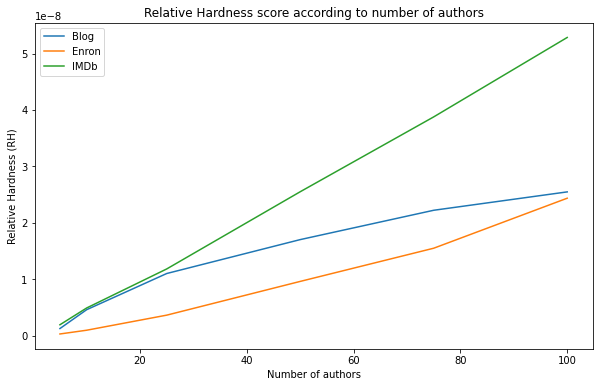

In [ ]:
# Plot of the hardness given the number of authors

plt.figure(figsize=(10,6))
plt.plot([5,10,25,50, 75, 100], rh_blog, label="Blog")
plt.plot([5,10,25,50, 75, 100], rh_enron, label="Enron")
plt.plot([5,10,25,50, 75, 100], rh_imdb, label="IMDb")
plt.legend()
plt.xlabel("Number of authors")
plt.ylabel("Relative Hardness (RH)")
plt.title("Relative Hardness score according to number of authors")
plt.show()

In [ ]:
df = pd.read_csv("full_imdb62.csv")

In [ ]:
df = df[df['content'].apply(lambda x: len(str(x).split()) > 30)]

# IV. Core function

The function below:
- processes the dataframe and extracts features needed by some methods
- runs for 5, 10, 25, 50, 75 and 100 authors:
  - a logistic regression classifier on top of TF-IDF + Preprocessing
  - WhoBert
  - Style-only classifier
  - WhoBert Style
- returns the output performance and a graph

In [ ]:
# This is needed in case you want to try the Longtransformer for longer texts (we did not obtain better results)
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

# Long-sequences for Blog authorship attribution
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
config = AutoConfig.from_pretrained('allenai/longformer-base-4096',num_labels=5)
model_long = AutoModelForSequenceClassification.from_pretrained('allenai/longformer-base-4096',config=config)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

On Enron, the following function takes ± 6 hours to run

In [ ]:
def run_iterations(source="enron", recompute = False):

  # Load data and remove emails containing the sender's name

  print("Loading and processing dataframe")

  ## Pre-processing functions
  def is_name_in_email(name, email):
    """
    Removing emails from Enron where name is in email
    """

    if str(name).lower() in str(email).lower():
      return 1
    else:
      return 0

  def fil_sent(sent):
      """
      Filter stopwords
      """

      filtered_sentence = ' '.join([w for w in sent.split() if not w in stop_words])
      return filtered_sentence

  def process(sent):
      """
      Apply stemming
      """

      sent = str(sent)
      return fil_sent(' '.join([ps.stem(str(x).lower()) for x in word_tokenize(sent)]))

  stop_words = set(stopwords.words('english'))
  ps = PorterStemmer() 

  def extract_style(text):
    """
    Extracting stylometric features of a text
    """

    text = str(text)
    len_text = len(text)
    len_words = len(text.split())
    avg_len = np.mean([len(t) for t in text.split()])
    num_short_w = len([t for t in text.split() if len(t) < 3])
    per_digit = sum(t.isdigit() for t in text)/len(text)
    per_cap = sum(1 for t in text if t.isupper())/len(text)
    f_a = sum(1 for t in text if t.lower() == "a")/len(text)
    f_b = sum(1 for t in text if t.lower() == "b")/len(text)
    f_c = sum(1 for t in text if t.lower() == "c")/len(text)
    f_d = sum(1 for t in text if t.lower() == "d")/len(text)
    f_e = sum(1 for t in text if t.lower() == "e")/len(text)
    f_f = sum(1 for t in text if t.lower() == "f")/len(text)
    f_g = sum(1 for t in text if t.lower() == "g")/len(text)
    f_h = sum(1 for t in text if t.lower() == "h")/len(text)
    f_i = sum(1 for t in text if t.lower() == "i")/len(text)
    f_j = sum(1 for t in text if t.lower() == "j")/len(text)
    f_k = sum(1 for t in text if t.lower() == "k")/len(text)
    f_l = sum(1 for t in text if t.lower() == "l")/len(text)
    f_m = sum(1 for t in text if t.lower() == "m")/len(text)
    f_n = sum(1 for t in text if t.lower() == "n")/len(text)
    f_o = sum(1 for t in text if t.lower() == "o")/len(text)
    f_p = sum(1 for t in text if t.lower() == "p")/len(text)
    f_q = sum(1 for t in text if t.lower() == "q")/len(text)
    f_r = sum(1 for t in text if t.lower() == "r")/len(text)
    f_s = sum(1 for t in text if t.lower() == "s")/len(text)
    f_t = sum(1 for t in text if t.lower() == "t")/len(text)
    f_u = sum(1 for t in text if t.lower() == "u")/len(text)
    f_v = sum(1 for t in text if t.lower() == "v")/len(text)
    f_w = sum(1 for t in text if t.lower() == "w")/len(text)
    f_x = sum(1 for t in text if t.lower() == "x")/len(text)
    f_y = sum(1 for t in text if t.lower() == "y")/len(text)
    f_z = sum(1 for t in text if t.lower() == "z")/len(text)
    f_1 = sum(1 for t in text if t.lower() == "1")/len(text)
    f_2 = sum(1 for t in text if t.lower() == "2")/len(text)
    f_3 = sum(1 for t in text if t.lower() == "3")/len(text)
    f_4 = sum(1 for t in text if t.lower() == "4")/len(text)
    f_5 = sum(1 for t in text if t.lower() == "5")/len(text)
    f_6 = sum(1 for t in text if t.lower() == "6")/len(text)
    f_7 = sum(1 for t in text if t.lower() == "7")/len(text)
    f_8 = sum(1 for t in text if t.lower() == "8")/len(text)
    f_9 = sum(1 for t in text if t.lower() == "9")/len(text)
    f_0 = sum(1 for t in text if t.lower() == "0")/len(text)
    f_e_0 = sum(1 for t in text if t.lower() == "!")/len(text)
    f_e_1 = sum(1 for t in text if t.lower() == "-")/len(text)
    f_e_2 = sum(1 for t in text if t.lower() == ":")/len(text)
    f_e_3 = sum(1 for t in text if t.lower() == "?")/len(text)
    f_e_4 = sum(1 for t in text if t.lower() == ".")/len(text)
    f_e_5 = sum(1 for t in text if t.lower() == ",")/len(text)
    f_e_6 = sum(1 for t in text if t.lower() == ";")/len(text)
    f_e_7 = sum(1 for t in text if t.lower() == "'")/len(text)
    f_e_8 = sum(1 for t in text if t.lower() == "/")/len(text)
    f_e_9 = sum(1 for t in text if t.lower() == "(")/len(text)
    f_e_10 = sum(1 for t in text if t.lower() == ")")/len(text)
    f_e_11 = sum(1 for t in text if t.lower() == "&")/len(text)
    richness = len(list(set(text.split())))/len(text.split())

    return pd.Series([avg_len, len_text, len_words, num_short_w, per_digit, per_cap, f_a, f_b, f_c, f_d, f_e, f_f, f_g, f_h, f_i, f_j, f_k, f_l, f_m, f_n, f_o, f_p, f_q, f_r, f_s, f_t, f_u, f_v, f_w, f_x, f_y, f_z, f_0, f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_e_0, f_e_1, f_e_2, f_e_3, f_e_4, f_e_5, f_e_6, f_e_7, f_e_8, f_e_9, f_e_10, f_e_11, richness])

  list_senders = [5, 10, 25, 50, 75, 100]

  if source == "enron":

    if recompute:
      df = pd.read_csv('enron.csv')
      df['name'] = df['From'].apply(lambda x: x.split("'")[1].split(".")[0])
      df['name_in_mail'] = df.apply(lambda x: is_name_in_email(x['name'], x['content']), axis=1)
      df = df[df['name_in_mail'] == 0]
      df = df[df['content'].apply(lambda x: '-----' not in str(x))]
      df = df[df['content'].apply(lambda x: "@" not in str(x))]
      df = df[df['content'].apply(lambda x: "From: " not in str(x))]
      df = df[df['content'].apply(lambda x: len(str(x).split()) > 10)]
      df['content_tfidf'] = df['content'].parallel_apply(lambda x: process(x))
      df[["avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9",  "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]] = df['content'].parallel_apply(lambda x: extract_style(x))
      df.to_csv("full_enron.csv")
    else:
      df = pd.read_csv('full_enron.csv')
      df['name'] = df['From'].apply(lambda x: x.split("'")[1].split(".")[0])
      df['name_in_mail'] = df.apply(lambda x: is_name_in_email(x['name'], x['content']), axis=1)
      df = df[df['name_in_mail'] == 0]
      df = df[df['content'].apply(lambda x: '-----' not in str(x))]
      df = df[df['content'].apply(lambda x: "@" not in str(x))]
      df = df[df['content'].apply(lambda x: "From: " not in str(x))]
      df = df[df['content'].apply(lambda x: len(str(x).split()) > 10)]
      df.to_csv("full_enron2.csv")
      print(df.shape)

  elif source == "imdb":

    if recompute:
      df = pd.read_csv('full_imdb.csv', index_col = 0)
      df['content_tfidf'] = df['content'].parallel_apply(lambda x: process(x))
      df[["avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9",  "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]] = df['content'].parallel_apply(lambda x: extract_style(x))
      df.to_csv("full_imdb_feat.csv")
    else:
      df = pd.read_csv('full_imdb_feat.csv', index_col = 0)

  elif source == "imdb62":
    
    list_senders = [62]

    if recompute:

      df = pd.read_csv("imdb62.txt", sep="\t", header = None)
      df.columns = ["reviewid", "From", "Itemid", "grade", "title", "content"]
      df['content_tfidf'] = df['content'].parallel_apply(lambda x: process(x))
      df[["avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9",  "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]] = df['content'].parallel_apply(lambda x: extract_style(x))
      df.to_csv("full_imdb62.csv")

    else:
      
      df = pd.read_csv('full_imdb62.csv', index_col = 0)

  elif source == "blog":

    if recompute:
      df = pd.read_csv('blogtext.csv')
      df.columns = ["From", "Gender", "Age", "Topic", "Sign", "Date", "content"]
      df = df[df['content'].apply(lambda x: len(x.split())) > 0]
      df['content_tfidf'] = df['content'].parallel_apply(lambda x: process(x))
      df[["avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9",  "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]] = df['content'].parallel_apply(lambda x: extract_style(x))
      df.to_csv("full_blog.csv")
    else:
      df = pd.read_csv('full_blog.csv')
      # Keep longer texts
      #df = df[df['content'].apply(lambda x: len(str(x).split()) > 30)]

  list_scores = []
  list_f1 = []

  import nltk
  from nltk.util import ngrams
  from collections import Counter
  import heapq

  def return_best_bi_grams(text):
      bigrams = ngrams(text,2)

      data = dict(Counter(bigrams))
      list_ngrams = heapq.nlargest(100, data.keys(), key=lambda k: data[k])
      return list_ngrams

  def return_best_tri_grams(text):
      trigrams = ngrams(text,3)

      data = dict(Counter(trigrams))
      list_ngrams = heapq.nlargest(100, data.keys(), key=lambda k: data[k])
      return list_ngrams

  def find_freq_n_gram_in_txt(text, list_bigram, list_trigram):
      
      to_ret = []
      
      num_bigrams = len(Counter(zip(text,text[1:])))
      num_trigrams = len(Counter(zip(text,text[1:],text[2:])))

      for n_gram in list_bigram: 
          to_ret.append(text.count(''.join(n_gram))/num_bigrams)

      for n_gram in list_trigram: 
          to_ret.append(text.count(''.join(n_gram))/num_trigrams)

      return to_ret

  for limit in list_senders:

    print("Number of speakers : ", limit)

    # Select top N senders and build Train and Test

    list_spk = list(pd.DataFrame(df['From'].value_counts()[:limit]).reset_index()['index'])
    sub_df = df[df['From'].isin(list_spk)]
    sub_df = sub_df[['From', 'content',  'content_tfidf', "avg_len", "len_text", "len_words", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9", "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]]
    sub_df = sub_df.dropna()
    
    text = " ".join(sub_df['content'].values)
    list_bigram = return_best_bi_grams(text)
    list_trigram = return_best_tri_grams(text)

    print("Number of texts : ", len(sub_df))

    dict_nlp_enron = {}
    k=0

    for val in np.unique(sub_df.From):
        dict_nlp_enron[val] = k
        k += 1

    sub_df['Target'] = sub_df['From'].apply(lambda x: dict_nlp_enron[x])

    ind = train_test_split(sub_df[['content', 'Target']], test_size=0.2, stratify=sub_df['Target'])
    ind_train = list(ind[0].index)
    ind_test = list(ind[1].index)

    nlp_train = sub_df.loc[ind_train]
    nlp_test = sub_df.loc[ind_test]

    # TF-IDF + LR

    print("#####")
    print("Training TF-IDF")

    vectorizer = TfidfVectorizer() #ngram_range=(1,2), max_features=3000
    X_train = vectorizer.fit_transform(nlp_train['content_tfidf'])
    X_test =  vectorizer.transform(nlp_test['content_tfidf'])

    clf = LogisticRegression(random_state=0).fit(X_train, nlp_train['Target'])
    y_pred = clf.predict(X_test)
    score_lr = accuracy_score(nlp_test['Target'], y_pred)
    f1_lr = f1_score(nlp_test['Target'], y_pred, average="macro")
    
    if limit < 11:
      plot_confusion_matrix_from_data(nlp_test['Target'], y_pred)

    print("Training done, accuracy is : ", score_lr)
    print("Training done, f1-score is : ", f1_lr)

    # Bert + Classification Layer

    print("#####")
    print("Training BERT")

    #if source == "blog":
    #model = ClassificationModel('bert', 'bert-base-cased', limit, config, model_long, tokenizer, args={'reprocess_input_data': True, 'overwrite_output_dir': True}, use_cuda=True) 
    #else:
    model = ClassificationModel('bert', 'bert-base-cased', num_labels=limit, args={'reprocess_input_data': True, 'overwrite_output_dir': True,  'num_train_epochs' : 15}, use_cuda=True) 
    model.train_model(nlp_train[['content', 'Target']])

    predictions, raw_outputs = model.predict(list(nlp_test['content']))
    score_bert = accuracy_score(predictions, nlp_test['Target'])
    f1_bert = f1_score(predictions, nlp_test['Target'], average="macro")

    if limit < 11:
      plot_confusion_matrix_from_data(nlp_test['Target'], predictions)

    predictions, raw_out_train = model.predict(list(nlp_train['content']))
    
    print("Training done, accuracy is : ", score_bert)
    print("Training done, f1-score is : ", f1_bert)

    # Style-based classifier

    print("#####")
    print("Training style classifier")

    X_style_train = nlp_train[["avg_len", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9", "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]]
    X_style_test = nlp_test[["avg_len", "num_short_w", "per_digit", "per_cap", "f_a", "f_b", "f_c", "f_d", "f_e", "f_f", "f_g", "f_h", "f_i", "f_j", "f_k", "f_l", "f_m", "f_n", "f_o", "f_p", "f_q", "f_r", "f_s", "f_t", "f_u", "f_v", "f_w", "f_x", "f_y", "f_z", "f_0", "f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9", "f_e_0", "f_e_1", "f_e_2", "f_e_3", "f_e_4", "f_e_5", "f_e_6", "f_e_7", "f_e_8", "f_e_9", "f_e_10", "f_e_11", "richness"]]
    
    #clf = xgb.XGBClassifier().fit(X_style_train, nlp_train['Target'])
    clf = LogisticRegression(random_state=0).fit(X_style_train, nlp_train['Target'])
    y_pred = clf.predict(X_style_test)
    y_proba = clf.predict_proba(X_style_test)
    y_proba_train = clf.predict_proba(X_style_train)
    score_style = accuracy_score(nlp_test['Target'], y_pred)
    f1_style = f1_score(nlp_test['Target'], y_pred, average="macro")

    print("Training done, accuracy is : ", score_style)
    print("Training done, f1-score is : ", f1_style)

    # Model Combination

    print("#####")
    print("Model combination")

    feat_for_BERT_LR_train = np.concatenate([raw_out_train, y_proba_train], axis=1)
    feat_for_BERT_LR_test = np.concatenate([raw_outputs, y_proba], axis=1)

    clf = LogisticRegression(random_state=0).fit(feat_for_BERT_LR_train, nlp_train['Target'])
    #clf = xgb.XGBClassifier().fit(feat_for_BERT_LR_train, nlp_train['Target'])

    y_pred = clf.predict(feat_for_BERT_LR_test)
    score_comb = accuracy_score(nlp_test['Target'], y_pred)
    f1_comb = f1_score(nlp_test['Target'], y_pred, average="macro")

    print("Training done, accuracy is : ", score_comb)
    print("Training done, f1-score is : ", f1_comb)

    if limit < 11:
      plot_confusion_matrix_from_data(nlp_test['Target'], y_pred)

    # Character N-gram only

    print("#####")
    print("Character N-gram")

    feats_train = nlp_train['content'].apply(lambda x: find_freq_n_gram_in_txt(x, list_bigram, list_trigram)).values
    feats_test = nlp_test['content'].apply(lambda x: find_freq_n_gram_in_txt(x, list_bigram, list_trigram)).values
    
    feats_train = pd.DataFrame(feats_train)[0].apply(lambda x: pd.Series(x))
    feats_test = pd.DataFrame(feats_test)[0].apply(lambda x: pd.Series(x))

    #clf_char = xgb.XGBClassifier().fit(feats_train, nlp_train['Target'])
    clf_char = LogisticRegression(random_state=0).fit(feats_train, nlp_train['Target'])
    y_pred = clf_char.predict(feats_test)
    y_proba = clf_char.predict_proba(feats_test)
    y_proba_train = clf_char.predict_proba(feats_train)

    score_char = accuracy_score(nlp_test['Target'], y_pred)
    f1_char = f1_score(nlp_test['Target'], y_pred, average="macro")

    print("Training done, accuracy is : ", score_char)
    print("Training done, f1-score is : ", f1_char)

    # BERT + Style + Char N-gram

    print("#####")
    print("BERT + Style + Char N-gram")

    feat_for_BERT_full_train = np.concatenate([feat_for_BERT_LR_train, y_proba_train], axis=1)
    feat_for_BERT_full_test = np.concatenate([feat_for_BERT_LR_test, y_proba], axis=1)

    #clf = xgb.XGBClassifier().fit(feat_for_BERT_full_train, nlp_train['Target'])
    clf = LogisticRegression(random_state=0).fit(feat_for_BERT_full_train, nlp_train['Target'])

    y_pred = clf.predict(feat_for_BERT_full_test)
    score_comb_fin = accuracy_score(nlp_test['Target'], y_pred)
    f1_comb_fin = f1_score(nlp_test['Target'], y_pred, average="macro")
    print("Training done, accuracy is : ", score_comb_fin)
    print("Training done, f1-score is : ", f1_comb_fin)

    if limit < 11:
      plot_confusion_matrix_from_data(nlp_test['Target'], y_pred)

    # Store scores
    list_scores.append([limit, score_lr, score_bert, score_style, score_comb])
    list_f1.append([limit, f1_lr, f1_bert, f1_style, f1_comb])

  list_scores = np.array(list_scores)

  # Plot the output accuracy
  plt.figure(figsize=(12,8))
  plt.plot(list_scores[:,0], list_scores[:,1], label="TF-IDF + LR")
  plt.plot(list_scores[:,0], list_scores[:,2], label="Bert + Classification layer")
  plt.plot(list_scores[:,0], list_scores[:,3], label="Stylometric")
  plt.plot(list_scores[:,0], list_scores[:,4], label="Bert + Style")
  plt.title("Classification Accuracy depending on the number of speakers")
  plt.xlabel("Number of speakers")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  return list_scores, list_f1

Loading and processing dataframe
Number of speakers :  62
Number of texts :  61973
#####
Training TF-IDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9153691004437273
Training done, f1-score is :  0.915108426063819
#####
Training BERT


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.




Training done, accuracy is :  0.9285195643404599
Training done, f1-score is :  0.9288773083953599
#####
Training style classifier


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.05881403791851553
Training done, f1-score is :  0.02061672329267856
#####
Model combination
Training done, accuracy is :  0.9281968535699879
Training done, f1-score is :  0.9285306096927862
#####
Character N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.5319887051230335
Training done, f1-score is :  0.5032011750573437
#####
BERT + Style + Char N-gram
Training done, accuracy is :  0.9281968535699879
Training done, f1-score is :  0.9285306096927862


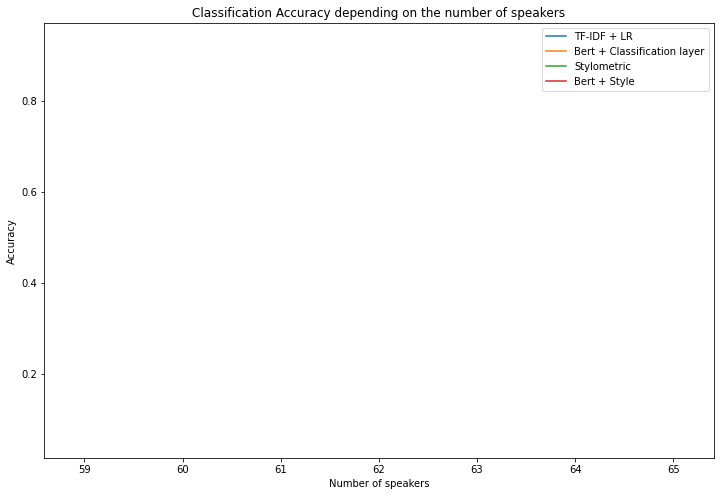

In [ ]:
# IMDB62
list_scores_imdb62 = run_iterations(source="imdb62")

Loading and processing dataframe


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



(131953, 111)
Number of speakers :  25
Number of texts :  39942
#####
Training TF-IDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9276505194642634
Training done, f1-score is :  0.9049048593670445
#####
Training BERT


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning:

Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0




Training done, accuracy is :  0.9869821003880336
Training done, f1-score is :  0.9810042634533717
#####
Training style classifier


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.35611465765427464
Training done, f1-score is :  0.08899684001754497
#####
Model combination


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9867317561647265
Training done, f1-score is :  0.9811993718479242
#####
Character N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.5317311303041682
Training done, f1-score is :  0.25870843801408694
#####
BERT + Style + Char N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9867317561647265
Training done, f1-score is :  0.9811993718479242
Number of speakers :  50
Number of texts :  51838
#####
Training TF-IDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9078896604938271
Training done, f1-score is :  0.8867520379004464
#####
Training BERT


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning:

Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0





Training done, accuracy is :  0.9811921296296297
Training done, f1-score is :  0.9709766469829408
#####
Training style classifier


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.20399305555555555
Training done, f1-score is :  0.027030406674668425
#####
Model combination


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9818672839506173
Training done, f1-score is :  0.9722495716014145
#####
Character N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.44849537037037035
Training done, f1-score is :  0.20606246818746668
#####
BERT + Style + Char N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9819637345679012
Training done, f1-score is :  0.9724308402749169
Number of speakers :  75
Number of texts :  59091
#####
Training TF-IDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.900583805736526
Training done, f1-score is :  0.8920756241374155
#####
Training BERT


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning:

Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0





Training done, accuracy is :  0.9758016752686353
Training done, f1-score is :  0.969283467147048
#####
Training style classifier


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.17319570183602673
Training done, f1-score is :  0.013962284477275032
#####
Model combination


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9752940181064388
Training done, f1-score is :  0.9688577183179634
#####
Character N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.4060411202301379
Training done, f1-score is :  0.20248416521899942
#####
BERT + Style + Char N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9754632371605043
Training done, f1-score is :  0.9690575859833376
Number of speakers :  100
Number of texts :  64470
#####
Training TF-IDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.8829688227082364
Training done, f1-score is :  0.8564184974404477
#####
Training BERT


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning:

Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0





Training done, accuracy is :  0.9701411509229099
Training done, f1-score is :  0.9455958724721916
#####
Training style classifier


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.15774778966961378
Training done, f1-score is :  0.009680473486434835
#####
Model combination


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9702962618272064
Training done, f1-score is :  0.9459960558820838
#####
Character N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.3689312858693966
Training done, f1-score is :  0.14732879844203953
#####
BERT + Style + Char N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.9705289281836513
Training done, f1-score is :  0.9464169114289729


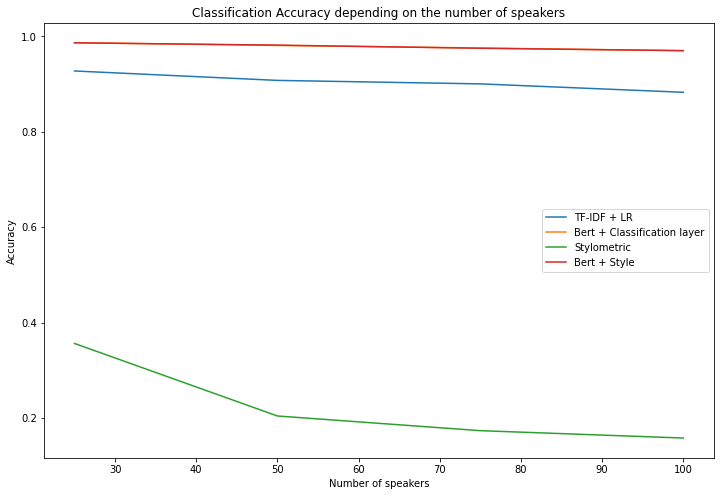

In [ ]:
# ENRON
list_scores_enron = run_iterations(source="enron")

In [ ]:
# Imdb Full
list_scores_imdb = run_iterations(source="imdb")

Loading and processing dataframe
Number of speakers :  75
Number of texts :  80959
#####
Training TF-IDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.7884670282614902
Training done, f1-score is :  0.7481609409616475
#####
Training BERT


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning:

Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Buffered data was truncated after reaching the output size limit.

Loading and processing dataframe
Number of speakers :  100
Number of texts :  112164
#####
Training TF-IDF


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.4051620380689163
Training done, f1-score is :  0.41303399154475956
#####
Training BERT


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning:

Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0





Training done, accuracy is :  0.5884188472339856
Training done, f1-score is :  0.5673013547792338
#####
Training style classifier


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.042482057682877904
Training done, f1-score is :  0.004616328664230379
#####
Model combination


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.5730842954575848
Training done, f1-score is :  0.5698566237458168
#####
Character N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.13841216065617618
Training done, f1-score is :  0.09049767823574281
#####
BERT + Style + Char N-gram


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training done, accuracy is :  0.5758480809521687
Training done, f1-score is :  0.5717768079414551


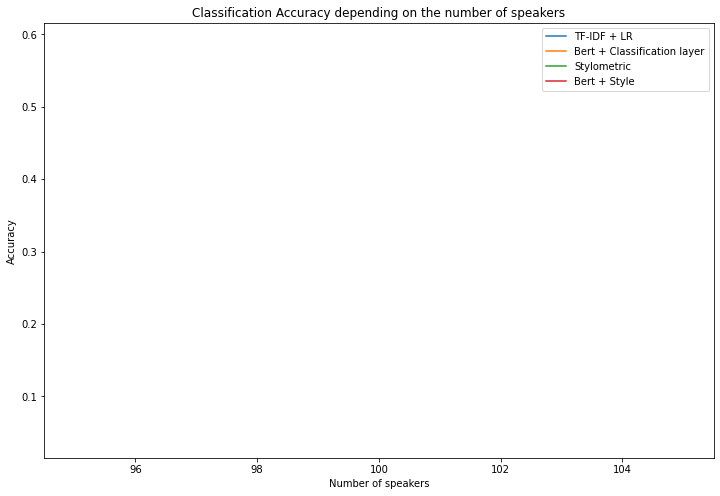

In [ ]:
# Blog dataset
list_scores_blog = run_iterations(source="blog")

**NB**: The next sections were used to build the function above. Changes that bring value should be reported in the function above to improve the results.

# V. Descriptive Statistics

In [ ]:
def descriptive_stats(df):

  print("DF shape: ", df.shape)
  print("Number of authors: ", len(np.unique(df['From']))) 
  print("Average number of texts per author: ", np.mean(df['From'].value_counts().values))
  print("Std of number of texts per author: ", np.std(df['From'].value_counts().values))
  print("Median number of texts per author: ", np.median(df['From'].value_counts().values))

  plot = False

  if plot:
    plt.figure(figsize=(12,8))
    plt.bar(range(100), df['From'].value_counts().values[:100])
    plt.title("Number of reviews per person, for the top 100 senders")
    plt.show()

    # Length of texts
    length_texts = list(df['content'].apply(lambda x: len(str(x).split())))
    length_texts_100 = [s for s in length_texts if s < 10000]
    print("Average length of texts: ", np.mean(length_texts))
    print("Median length of texts: ", np.median(length_texts))

  keep_res = []

  for lim in [62]: #[5, 10, 25, 50, 75, 100]:

    list_spk = list(pd.DataFrame(df['From'].value_counts()[:lim]).reset_index()['index'])
    df2 = df[df['From'].isin(list_spk)]

    length_texts = np.mean(df2['content'].apply(lambda x: len(str(x).split())))
    std_txt = np.std(df2['content'].apply(lambda x: len(str(x).split())))

    num_txt = np.mean(df2['From'].value_counts().values[:100])
    
    st = np.std(df2['From'].value_counts().values)
    
    keep_res.append([lim, length_texts, std_txt, num_txt, st])

  plt.figure(figsize=(10,6))
  plt.hist(length_texts_100, bins=30)
  plt.title("Distribution of reviews length for top 100 reviewers")
  plt.show()

  df3 = pd.DataFrame(keep_res)
  df3.columns = ["Num Auth", "Avg Length", "Std Lenth", "Avg Num", "Std Num"]
  return df3

DF shape:  (61987, 63)
Number of authors:  62
Average number of texts per author:  999.7903225806451
Std of number of texts per author:  0.8059675966870314
Median number of texts per author:  1000.0
Average length of texts:  340.91633729652995
Median length of texts:  274.0


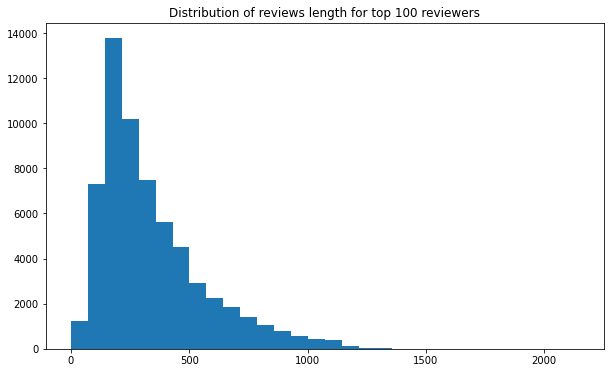

,Num Auth,Avg Length,Std Lenth,Avg Num,Std Num
0,62,340.916337,223.474031,999.790323,0.805968


In [ ]:
df = pd.read_csv("full_imdb62.csv")
descriptive_stats(df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



DF shape:  (445121, 99)
Number of authors:  16983
Average number of texts per author:  26.209798033327445
Std of number of texts per author:  264.49268865571537
Median number of texts per author:  3.0


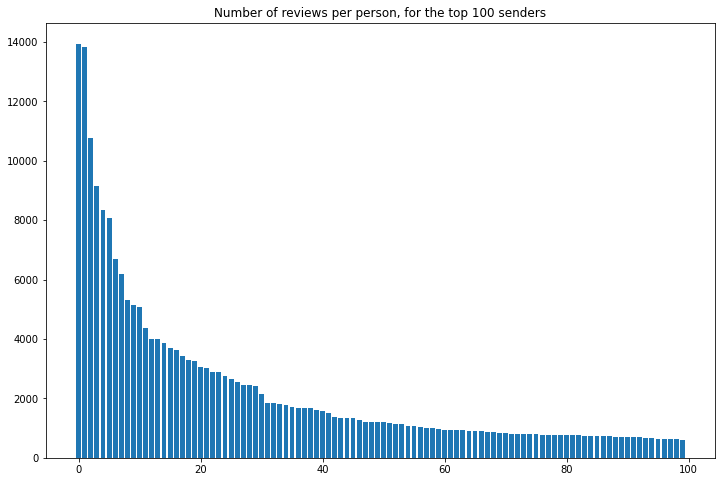

Average length of texts:  239.23301304589089
Median length of texts:  103.0


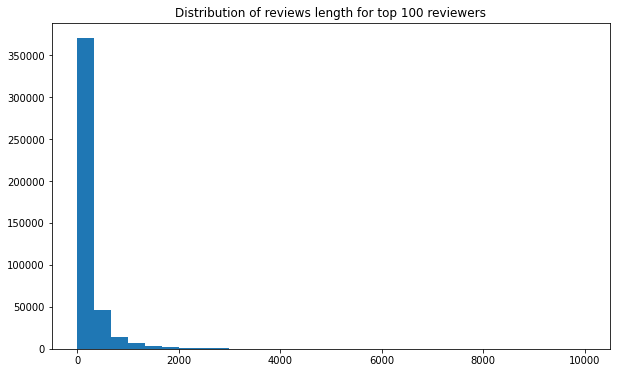

,Num Auth,Avg Length,Std Lenth,Avg Num,Std Num
0,5,189.781873,375.498218,11205.40,2323.961153
1,10,201.133661,419.209715,8744.50,3051.666143
2,25,184.583057,375.398429,5626.48,3230.451066
3,50,183.255159,361.091863,3685.08,3014.338241
4,75,193.874206,386.195103,2774.16,2778.809002
5,100,208.170420,716.984265,2258.89,2566.819261


In [ ]:
df = pd.read_csv("full_enron.csv")
descriptive_stats(df)

DF shape:  (271564, 7)
Number of authors:  22114
Average number of texts per author:  12.280184498507733
Std of number of texts per author:  92.09648965486684
Median number of texts per author:  1.0


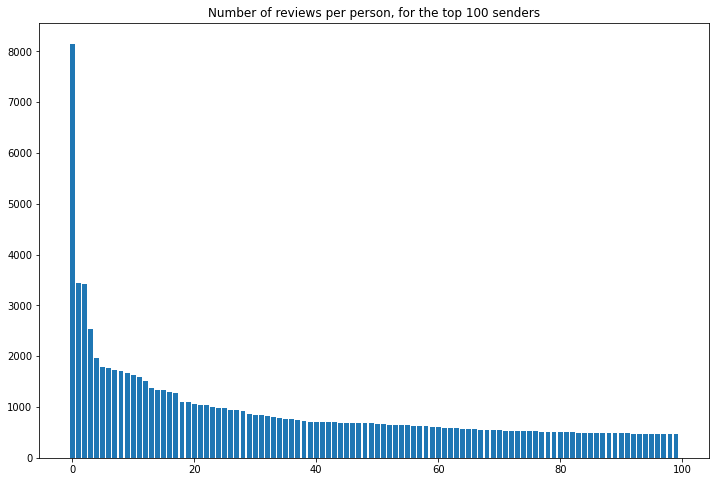

Average length of texts:  121.69725000368237
Median length of texts:  63.0


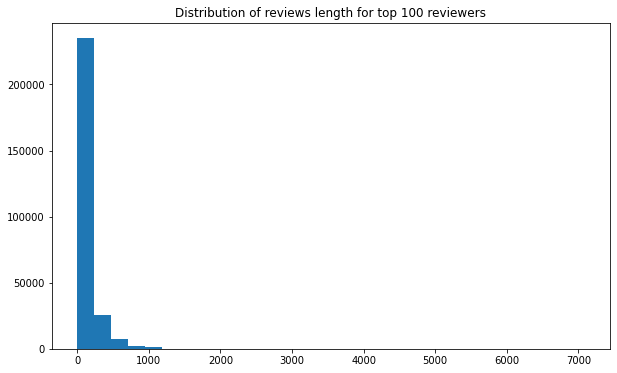

,Num Auth,Avg Length,Std Lenth,Avg Num,Std Num
0,5,106.145252,183.599481,3900.80,2197.483324
1,10,126.964790,185.335241,2817.40,1894.532829
2,25,109.877141,167.056418,1872.72,1434.156157
3,50,103.718401,152.223666,1324.08,1154.810700
4,75,102.412588,157.794223,1079.56,1004.638751
5,100,102.389065,156.814392,932.08,906.812425


In [ ]:
df = pd.read_csv("full_imdb.csv")
descriptive_stats(df)

DF shape:  (678165, 64)
Number of authors:  19320
Average number of texts per author:  35.10170807453416
Std of number of texts per author:  104.98727349267705
Median number of texts per author:  11.0


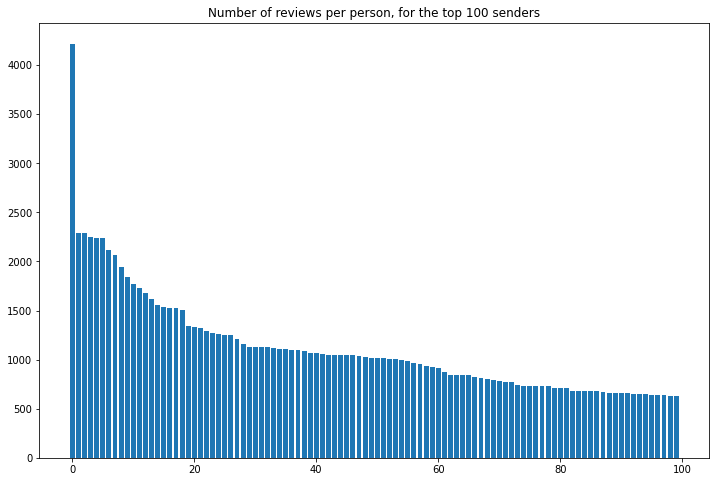

Average length of texts:  201.71019589627892
Median length of texts:  113.0


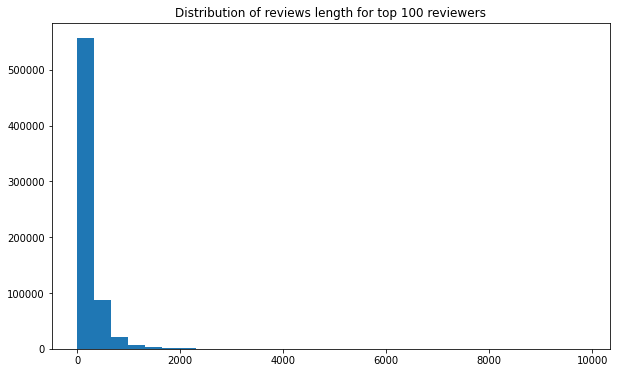

,Num Auth,Avg Length,Std Lenth,Avg Num,Std Num
0,5,78.619810,191.330490,2659.20,780.137270
1,10,90.539270,184.359306,2350.40,639.496239
2,25,98.623799,173.741877,1831.68,599.336147
3,50,98.371707,166.943989,1465.78,561.685510
4,75,119.630481,208.875818,1270.12,538.292014
5,100,126.424063,228.055860,1121.79,532.535657


In [ ]:
df = pd.read_csv("full_blog.csv")
descriptive_stats(df)

# VI. Evaluation

In [ ]:
df = pd.DataFrame([[5, 99.04, 99.12],
[10, 97.38, 97.38],
[25, 93.95, 94.90],
[50, 90.35, 92.51],
[75, 88.51, 91.33],
[100, 86.25, 89.48],
[5, 99.52, 99.57],
[10, 97.26, 97.43],
[25, 90.16, 90.55],
[50, 87.39, 88.12],
[75, 82.49, 83.61],
[100, 79.46, 81.13],
[5, 61.94, 60.68],
[10, 62.16, 61.97],
[25, 59.87, 60.32],
[50, 51.92, 51.97],
[75, 53.04, 53.44],
[100, 50.03, 50.77]])
df.columns = ["Num", "WhoBert", "WhoBert Style"]
df['diff'] = df['WhoBert Style'] - df['WhoBert']

df2 = pd.DataFrame(df.groupby(by="Num").mean()['diff']).reset_index()
px.bar(df2, x = "Num", y="diff", labels={'diff':'Average accuracy difference (%)', 'Num':'Number of authors'}, barmode='group', width=600)

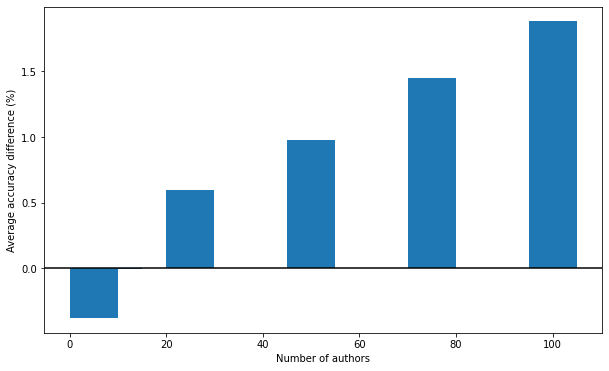

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(df2["Num"], df2["diff"], width=10)
plt.axhline(0, c='black')
plt.xlabel('Number of authors')
plt.ylabel('Average accuracy difference (%)')
plt.show()

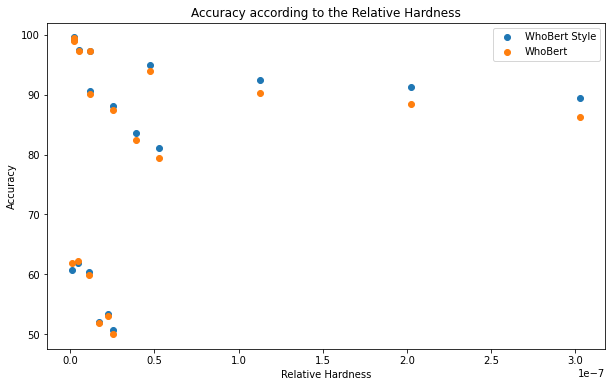

In [ ]:
rh_enron = [2.330491802161233e-09,
 1.1624687753304195e-08,
 4.7640030153438865e-08,
 1.1300660724208751e-07,
 2.0273796932661174e-07,
 3.0281611818715787e-07]

rh_blog = [1.2474156390217349e-09,
  4.587129589550378e-09,
 1.1002807596445477e-08,
 1.7050146900376367e-08,
 2.2114930247422566e-08,
 2.5339762255635504e-08]

rh_imdb = [1.919541690487672e-09,
 4.890248624901865e-09,
 1.1813652330160324e-08,
 2.5498294766458272e-08,
 3.876638085336687e-08,
 5.2839435870226196e-08]

df['data'] = rh_enron + rh_imdb + rh_blog

plt.figure(figsize=(10,6))
plt.scatter(df['data'], df["WhoBert Style"], label="WhoBert Style")
plt.scatter(df['data'], df["WhoBert"], label="WhoBert")
plt.xlabel("Relative Hardness")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy according to the Relative Hardness")
plt.show()